In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob 
import matplotlib.pyplot as plt
import matplotlib as mpl

sns.set_context("talk")
data_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/"


# load families summary
summary_homfam_exthomfam = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_exthomfam.csv")
summary_homfam = summary_homfam_exthomfam[summary_homfam_exthomfam.dataset == "homfam"]
families = summary_homfam.drop(["subset", "file", "min_length", "max_length", "perc_ref_total", "dataset"], axis = 1)

# Load similarities 
evaluation_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/"
sims = os.path.join(evaluation_dir,"homfam/evaluation/sim/*FAMSA.MBED.sim")
sim_df = pd.DataFrame()
for file in list(glob.glob(sims)):
    full_name = file.split(sep = "/")[-1].replace(".sim", "")
    file_opened = open(file, "r")
    tot_line = [line.split() for line in file_opened if line.startswith('TOT')]
    entry = pd.DataFrame({'name': [full_name],"sim_tot": tot_line[0][3]})
    sim_df =  pd.concat([sim_df, entry], ignore_index = True)

    
sim_df["family"] = sim_df.name.str.split(".", expand = True)[0]
sim_df["family"] = sim_df.family.str.replace("-ref", "")
sim_df = sim_df.rename(columns = {"sim_tot": "sim"})
families = pd.merge(families,sim_df)
families["family_real"]= families.family
families["family"] = families.family_real+"-ref"
families = families.drop(["family_real", "name"], axis = 1)
families["sim"] = families.sim.astype(float)

# load irmsd scores
def get_irmsd(score_files): 
    def parse_score(score_file):
        df = pd.read_csv(score_file, sep = ":", skiprows=1, header = None )
        df.columns = ["metric", "val"]
        df.metric = df.metric.str.split("\s+", expand = True)[2]
        df.val = df.val.str.split("\s+",expand = True)[1]
        df.index = df.metric
        df = df.drop("metric", axis = 1)
        df = df.T.reset_index().drop("index", axis = 1)
        name = os.path.basename(score_file).replace(".total_irmsd", "")
        df["name"] = name
        return(df)
    scores = pd.concat(list(map(parse_score, score_files)))
    return(scores)


# get normal scores
def get_refs(score_files): 
    def parse_score(score_file): 
        return(pd.read_csv(score_file,sep = ";", header = None).drop(4, axis = 1))

    scores = pd.concat(list(map(parse_score, score_files)))
    scores = scores.iloc[:,0:4]
    scores.columns = ['name', 'sp', 'tc', 'column']
    return(scores)

def get_scores(pattern, ref = False): 
    if ref: 
        pattern = "*-ref"+pattern
    else:
        pattern = "*[!ref]"+pattern 
    print(pattern)
    df1 = get_irmsd((glob.glob(os.path.join(data_dir, "evaluation/irmsd/"+pattern+"irmsd"))))
    df2 = get_refs((glob.glob(os.path.join(data_dir, "evaluation/score/"+pattern))))
    return(df1.merge(df2, on = "name"))

def plot_scatter_perc(df1,df2,xlabel,ylabel,
                      palette = sns.dark_palette("#3399FF", reverse = True, as_cmap=True),
                      log = True, 
                      title = "regressive on homfam", hue_var = "sim", metric = "tc", size_fig = 1): 
    f, ax = plt.subplots(figsize=(8*size_fig,6.4*size_fig ))
    
    # Prep df 
    df = df1.merge(df2, on = ["family", hue_var])
    
    
    hue = df[hue_var]
    # colorbar 
    norm = mpl.colors.Normalize( vmin=0, vmax=100)
    sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
    sm.set_array([])
    
    # Color bar 
    cbar =ax.figure.colorbar(sm, ticks=[0,50,100], format=mpl.ticker.ScalarFormatter())
    cbar.ax.set_yticklabels(["0", "50", "100"]) 
    cbar.ax.set_ylabel('avg % similarity', rotation=270, labelpad = 20, fontsize = "small")
    
    metric_x = metric+"_x"
    metric_y = metric+"_y"
    # Plot 
    ax = sns.scatterplot(data = df, x = metric_x,
                    y = metric_y,
                    hue = hue_var,
                    s = 100,
                    palette = palette)

    # % above the line
    perc_y_better_than_x = (len(list(filter(lambda ele: ele == True, list(df[metric_x] <= df[metric_y])))) / len(list(df[metric_x]  >= df[metric_y] ))) * 100
    
    # Diagonal line
    ax.axline((1, 1), slope=1, ls="--", c=".2", lw = 0.8)
    
    ax.set(xlim = (0,100), ylim = (0,100))
    ax.get_legend().remove()
    
    # Axis labels
    ax.set(xlabel=xlabel,
           ylabel=ylabel,
           title = title + "\n metric: "+metric+"\n (n = "+str(len(df[metric_x] ))+") \n\n % y >= x  "+str(round(perc_y_better_than_x,1))+" \n")


In [4]:
# Now check on few families, with N=100, famsa, mafft-ginsi 
fams = ["hip", "cryst", "seatoxin", "blmb", "DEATH", "sdr", "Acetyltransf"]
methods = ["MAFFT-GINSI", "FAMSA"]
bucket_size = "100"
cols = ["family", "iRMSD", "NiRMSD", "method", "sp", "tc", "APDB", "EVALUATED"]

ref = True


# REGRESSIVE FAMSA and MAFFT GINSI 
str_coffee = get_scores(".progressive.3DCOFFE*.MBED*", ref)
str_coffee[["family", "method_gen", "method", "tree_method"]] = str_coffee.name.str.split(".", expand = True)
str_coffee = pd.merge(str_coffee, families, on = "family")


# REGRESSIVE FAMSA and MAFFT GINSI 
foldseek = get_scores(".foldseek*.MBED*", ref)
foldseek[["family", "method_gen", "tree_method", "method"]] = foldseek.name.str.split(".", expand = True)
foldseek = pd.merge(foldseek, families, on = "family")


# FAMSA
famsa = get_scores(".progressive.*FAMSA.MBED*",ref)
famsa[["family", "method", "tree_method","library_method"]] = famsa.name.str.split(".", expand = True)
famsa["method"] = "FAMSA"
famsa = pd.merge(famsa, families, on = "family")

#regressive_sequence= get_scores(".regressive.*.MBED*", ref)
#regressive_sequence[["family", "algo","bucket", "align_method" , "tree_method"]] = regressive_sequence.name.str.split(".", expand = True)
#regressive_sequence = pd.merge(regressive_sequence, families, on = "family")
#regressive_sequence = regressive_sequence[(regressive_sequence.family.isin(fams)) & (regressive_sequence.bucket == bucket_size) & (regressive_sequence.align_method.isin(methods))]
#regressive_sequence["method"] = regressive_sequence.algo + "_" + regressive_sequence["align_method"]
#regressive_mafft = regressive_sequence[regressive_sequence.method == "regressive_MAFFT-GINSI"]
scores = pd.concat([str_coffee[cols], foldseek[cols],famsa[cols]])
scores["family_ext"] = scores.family
#if ref: 
#    scores.family = scores.family_ext.str.replace("-ref", "")
scores = pd.merge(scores, families, on = "family")
#cols_ext = cols +["family_ext", "n_sequences"]
#scores = scores[cols_ext]
scores.NiRMSD = scores.NiRMSD.astype(float)
scores.iRMSD = scores.iRMSD.astype(float)
scores.APDB = scores.APDB.astype(float)
scores.EVALUATED = scores.EVALUATED.astype(float)

#scores = scores[scores.family.isin(fams)]

*-ref.progressive.3DCOFFE*.MBED*
*-ref.foldseek*.MBED*
*-ref.progressive.*FAMSA.MBED*


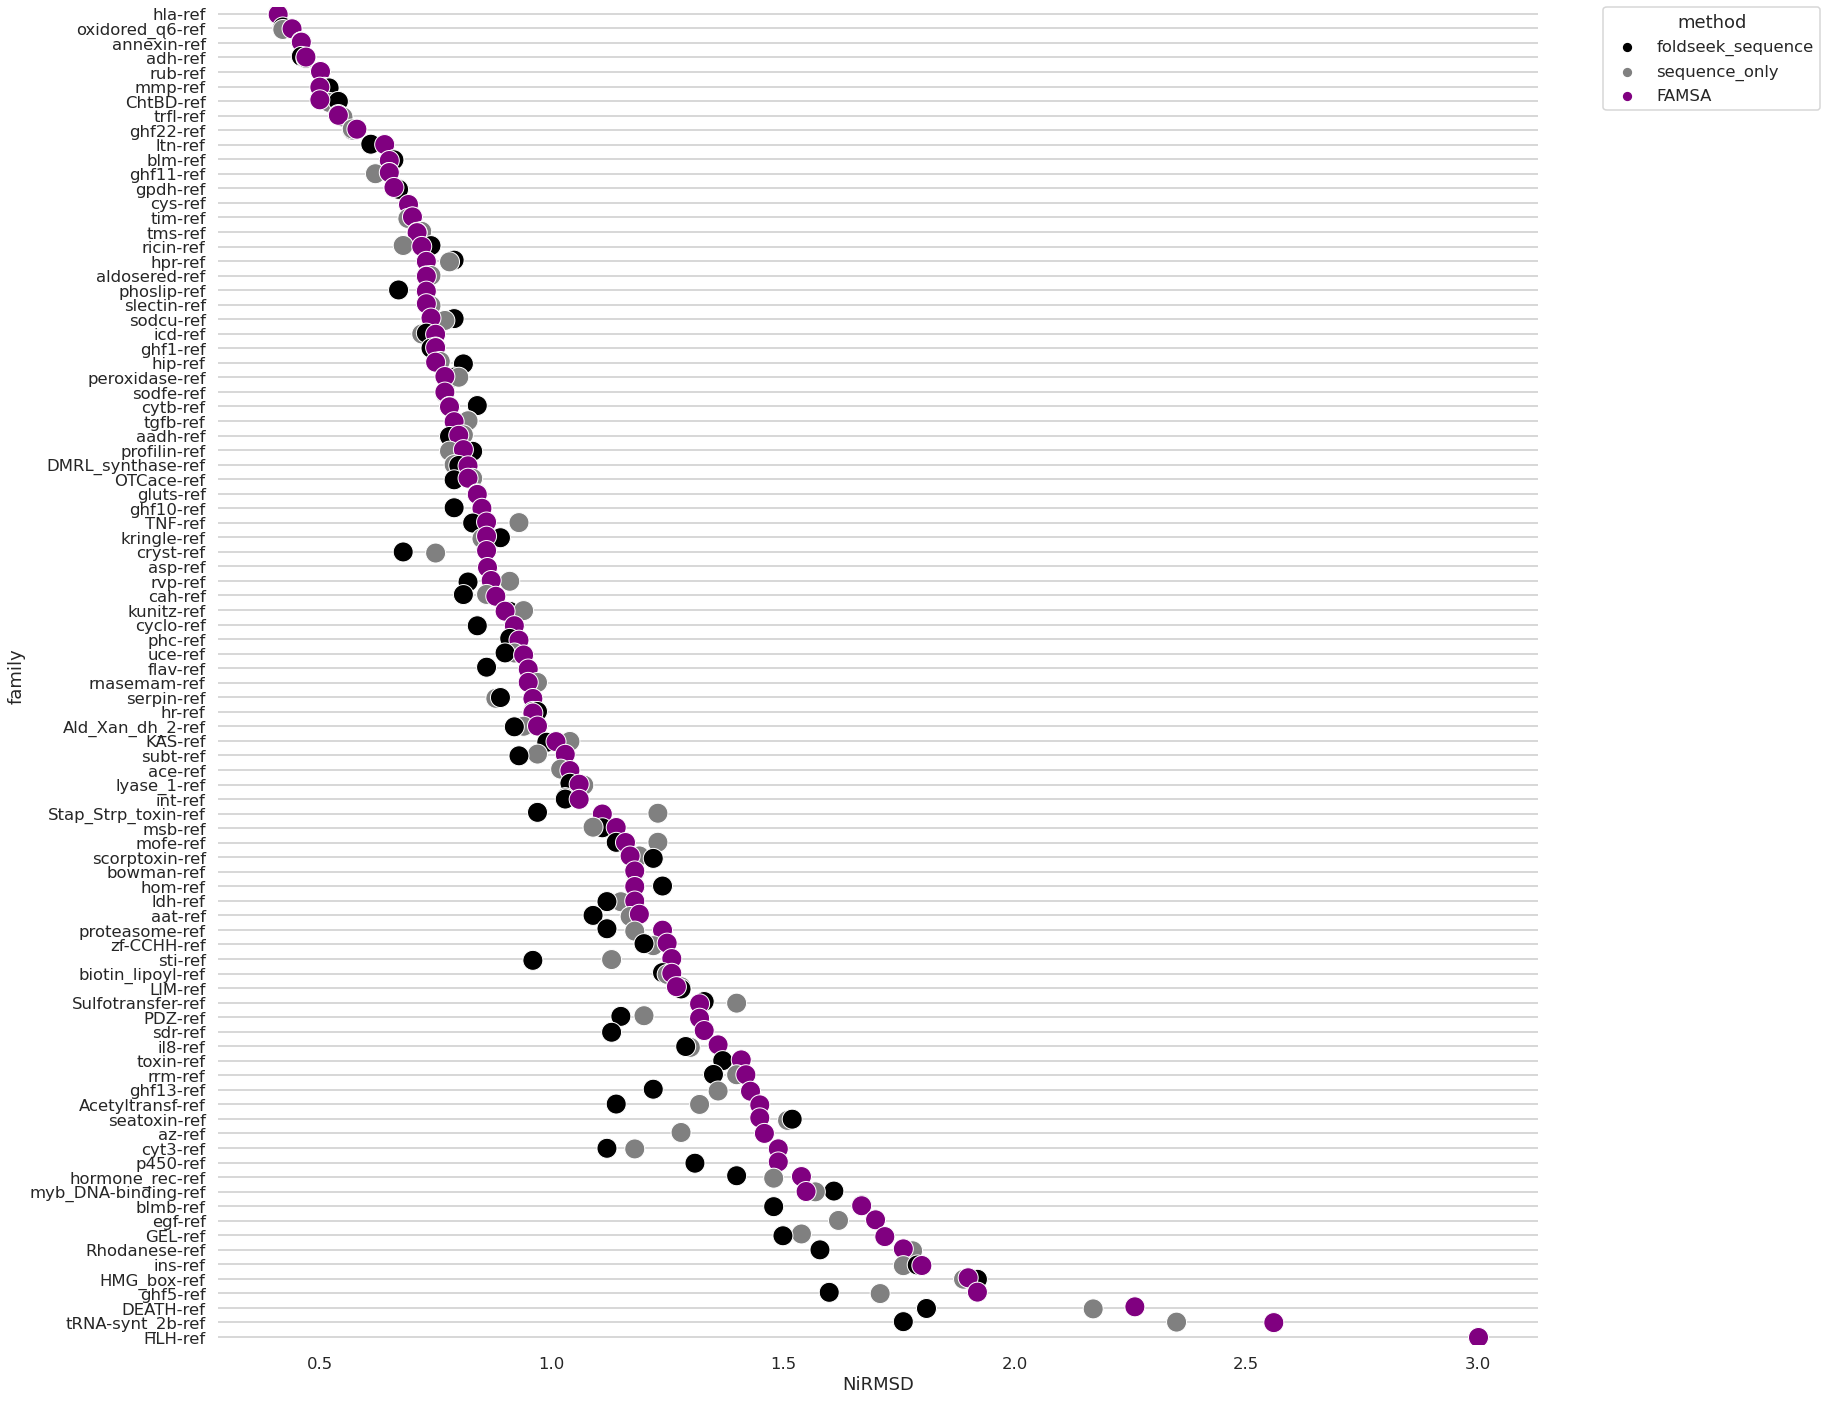

In [10]:


eval_var = "NiRMSD"


import itertools
sns.set_theme(style="whitegrid")
sns.set_context("talk")

sorting_method = "FAMSA"

scores = scores[scores.method.isin(["FAMSA", "foldseek_sequence", "sequence_only"])]

sorter = scores[scores.method == sorting_method].sort_values(eval_var).family.to_frame()
scores = pd.merge(sorter,scores, on = "family", how = 'left')

# Create an array with the colors you want to use
colors = list(itertools.chain.from_iterable([["black","grey", "purple", "blue", "red", "pink"],["orange"]*100]))

# colors = ["red", "blue", "grey", "black", "grey", "grey", rep(c("orag"))]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))


g = sns.PairGrid(scores,
                 x_vars=eval_var, y_vars=["family"], hue = "method",
                 height=20, aspect=1)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=20, orient="h", jitter=True,
       linewidth=1, edgecolor="w")


for ax in g.axes.flat:
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = "method")

In [6]:
scores

,family,iRMSD,NiRMSD,method,sp,tc,APDB,EVALUATED,family_ext,n_sequences,mean_length,size_group,sim
0,hla-ref,0.36,0.41,3DCOFFEEEXPERIMENTAL,100.0,100.0,95.87,89.72,hla-ref,13465,153.147642,large,76.46
1,hla-ref,0.36,0.41,3DCOFFEE,100.0,100.0,95.87,89.72,hla-ref,13465,153.147642,large,76.46
2,hla-ref,0.36,0.41,foldseek_sequence,100.0,100.0,95.87,89.72,hla-ref,13465,153.147642,large,76.46
3,hla-ref,0.36,0.41,sequence_only,100.0,100.0,95.87,89.72,hla-ref,13465,153.147642,large,76.46
4,hla-ref,0.36,0.41,foldseek_only,100.0,100.0,95.87,89.72,hla-ref,13465,153.147642,large,76.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,tRNA-synt_2b-ref,1.21,2.56,FAMSA,48.4,15.7,54.68,47.22,tRNA-synt_2b-ref,11293,177.564155,large,21.24
598,HLH-ref,0.92,2.89,3DCOFFEEEXPERIMENTAL,89.5,76.2,54.50,31.83,HLH-ref,6781,53.545347,medium,27.98
599,HLH-ref,0.94,2.96,3DCOFFEE,89.2,78.6,54.29,31.67,HLH-ref,6781,53.545347,medium,27.98
600,HLH-ref,1.04,3.55,foldseek_only,81.9,54.8,51.55,29.26,HLH-ref,6781,53.545347,medium,27.98


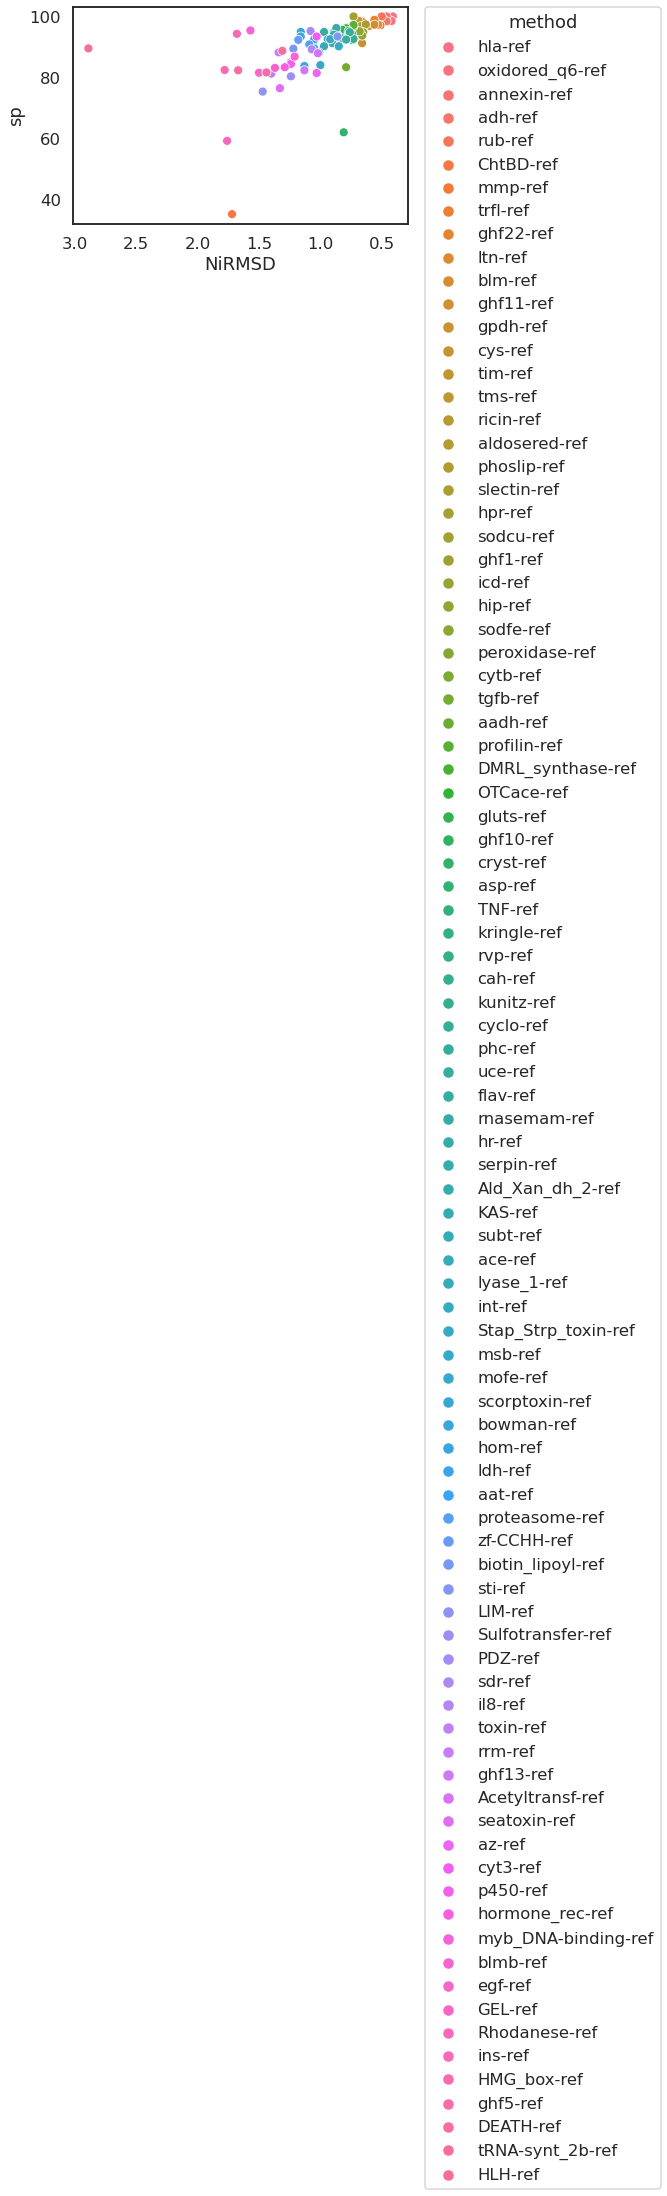

In [7]:
sns.set_theme(style="white")
sns.set_context("talk")

scores_df = scores[scores.method == "3DCOFFEEEXPERIMENTAL"]




ax = sns.scatterplot(data=scores_df, y="sp", x="NiRMSD", hue = "family")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = "method")
ax.invert_xaxis()

In [60]:
scores_df

,family,iRMSD,NiRMSD,method,sp,tc,APDB,EVALUATED,family_ext,n_sequences,mean_length,size_group,sim
1,phc-ref,0.72,0.89,3DCOFFEEEXPERIMENTAL,94.7,72.6,72.16,80.72,phc-ref,2957,98.471086,small,37.09
7,ldh-ref,0.89,1.05,3DCOFFEEEXPERIMENTAL,92.5,67.6,64.48,84.73,ldh-ref,7367,121.378309,medium,31.81
14,oxidored_q6-ref,0.39,0.42,3DCOFFEEEXPERIMENTAL,98.5,94.4,94.93,92.67,oxidored_q6-ref,3348,123.043608,small,56.68
22,hr-ref,0.87,0.97,3DCOFFEEEXPERIMENTAL,94.9,88.6,62.13,90.64,hr-ref,3707,65.151335,small,53.31
29,sodfe-ref,0.61,0.68,3DCOFFEEEXPERIMENTAL,95.1,78.5,81.30,89.70,sodfe-ref,4455,77.447138,medium,43.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,icd-ref,0.66,0.71,3DCOFFEEEXPERIMENTAL,95.5,86.2,79.97,92.20,icd-ref,5678,328.887460,medium,42.08
577,hormone_rec-ref,0.98,1.29,3DCOFFEEEXPERIMENTAL,83.3,55.9,55.37,76.12,hormone_rec-ref,3509,188.562268,small,22.47
584,ace-ref,0.85,0.97,3DCOFFEEEXPERIMENTAL,90.2,76.3,69.84,88.27,ace-ref,3989,427.823765,small,37.43
591,ghf11-ref,0.54,0.56,3DCOFFEEEXPERIMENTAL,97.3,92.7,87.62,96.04,ghf11-ref,521,167.758157,small,50.02
